In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import iqr
from scipy.stats import shapiro
import pylab

def draw_roc( actual, probs, title ): # module for ROC Curve
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

    return None

# Data Understanding and Exploration

In [2]:
# reading the dataset
df = pd.read_csv('breast_cancer_data.csv')

In [3]:
# displaying 1st 5 rows of the dataset
df.head()

,BI_RADS,Age,Shape,Margin,Mass_Density,Severity
0,5.0,67.0,lobular,spiculated,low,1
1,4.0,43.0,round,circumscribed,NaN,1
2,5.0,58.0,irregular,spiculated,low,1
3,4.0,28.0,round,circumscribed,low,0
4,5.0,74.0,round,spiculated,NaN,1


In [4]:
# brief information about the dataset regarding data type of variables and number of non-null instances in each of them
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 6 columns):
BI_RADS         959 non-null float64
Age             861 non-null float64
Shape           930 non-null object
Margin          913 non-null object
Mass_Density    885 non-null object
Severity        961 non-null int64
dtypes: float64(2), int64(1), object(3)
memory usage: 45.1+ KB


# Data Cleaning

In [5]:
# calculating the % of NaN values for each and every column:
null_percentage = pd.DataFrame(100*df.isnull().sum(axis = 0)/df.shape[0], columns = ['%_of_null_values'])

In [6]:
# displaying columns containing NaN values with % of NaN values in them
null_percentage.loc[(null_percentage['%_of_null_values'] > 0),:].sort_values('%_of_null_values', ascending = False)

,%_of_null_values
Age,10.405827
Mass_Density,7.908429
Margin,4.994797
Shape,3.225806
BI_RADS,0.208117


In [7]:
# Imputing the continuous feature, Age with median
df.loc[df.isnull()['Age'], ['Age']] = df['Age'].median()
# Imputing the categorical features, Mass_Density, Margin, Shape and BI_RADS with mode
df.loc[df.isnull()['Mass_Density'], ['Mass_Density']] = df['Mass_Density'].mode()[0]
df.loc[df.isnull()['Margin'], ['Margin']] = df['Margin'].mode()[0]
df.loc[df.isnull()['Shape'], ['Shape']] = df['Shape'].mode()[0]
df.loc[df.isnull()['BI_RADS'], ['BI_RADS']] = df['BI_RADS'].mode()[0]

# Exploratory Data Analysis (EDA)

## 1. Univariate Analysis

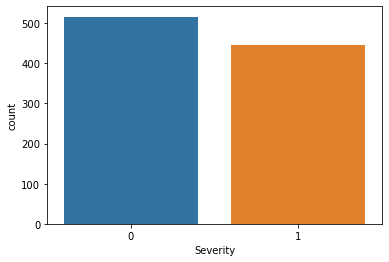

In [8]:
# class category count i.e., class distribution of target variable, Severity
sns.countplot(data = df, x = 'Severity')

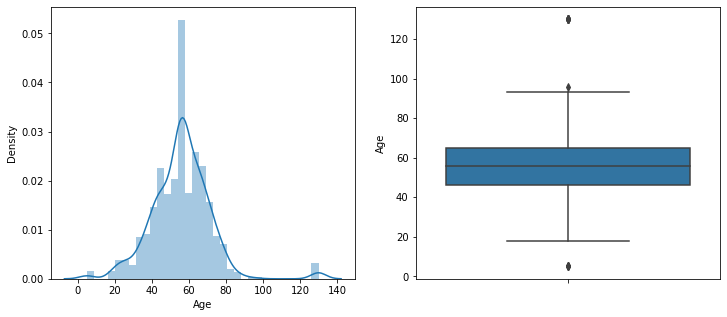

In [9]:
# Distribition Plot and Box Plot of Continuous Variable, Age
plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
sns.distplot(df['Age'])
plt.subplot(1, 2, 2)
sns.boxplot(data = df, y = 'Age')
plt.show()

### From the Distribution Plot, it can be concluded visually that the continuous feature variable, Age is  NOT normally distributed as the spread on either side is uneven
### The Box-plot shows the outliers, which are later properly capped at both lower and upper ends (limits)

In [10]:
# Shapiro-Wilk Test on Age Feature (statistical test for Normal Distribution)
shapiro(df['Age'])

(0.9250088930130005, 1.776654708793192e-21)

### The p-Value from the Shapiro-Wilk Test is 1.776e-21, which is way less than 0.05, hence the distribution of Age attribute CANNOT BE ASSUMED A NORMAL DISTRIBUTION statistically

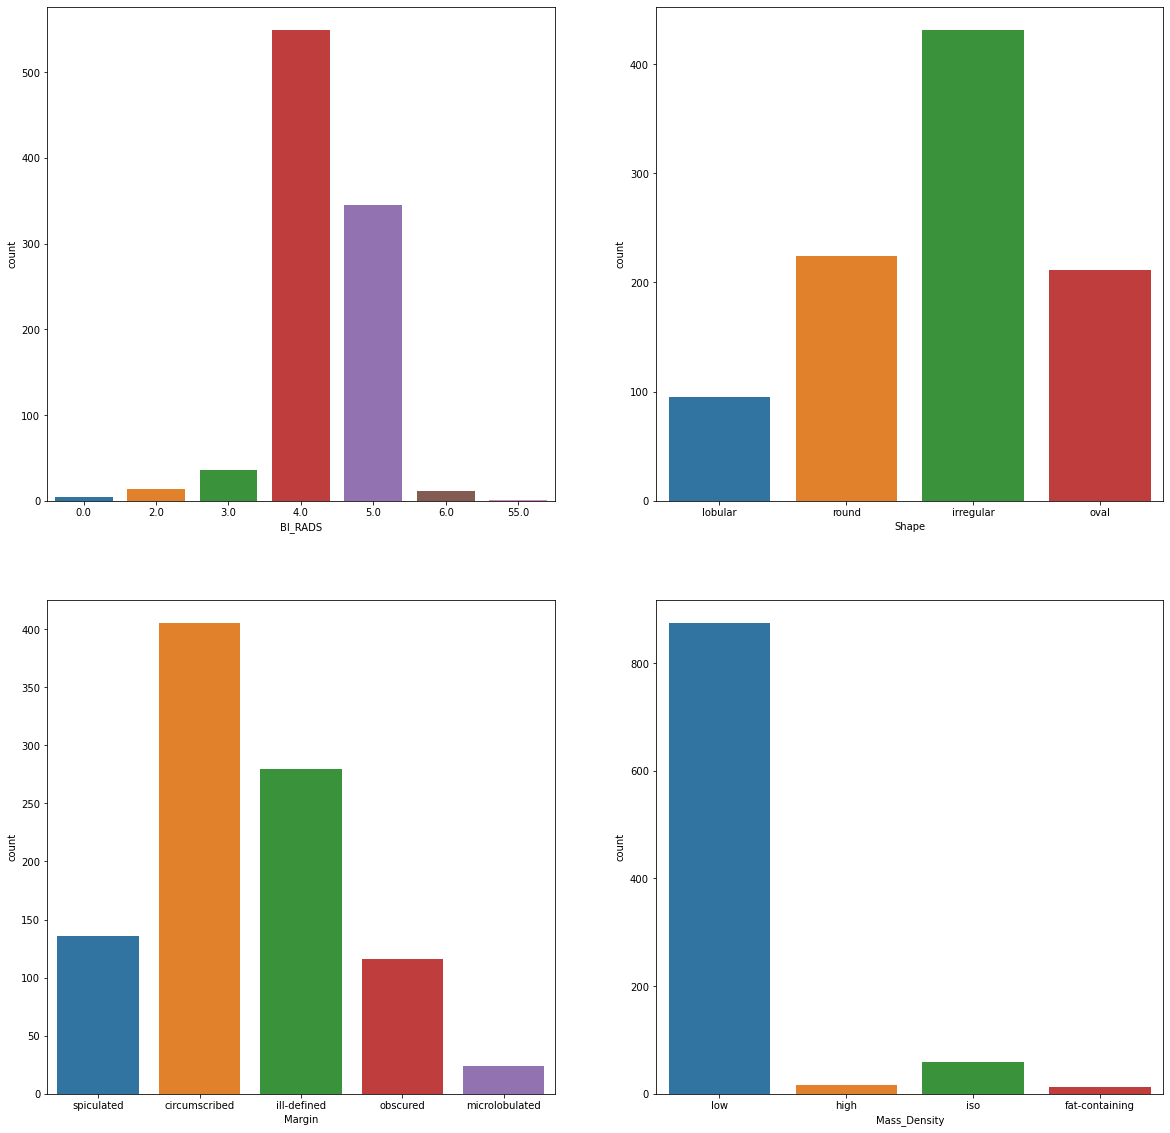

In [11]:
# Category Count Distribution of Categorical Variables, BI_RADS, Shape, Margin and Mass_Density
plt.figure(figsize = (20, 20))
plt.subplot(2, 2, 1)
sns.countplot(data = df, x = 'BI_RADS')
plt.subplot(2, 2, 2)
sns.countplot(data = df, x = 'Shape')
plt.subplot(2, 2, 3)
sns.countplot(data = df, x = 'Margin')
plt.subplot(2, 2, 4)
sns.countplot(data = df, x = 'Mass_Density')
plt.show()

## 2. Bivariate Analysis

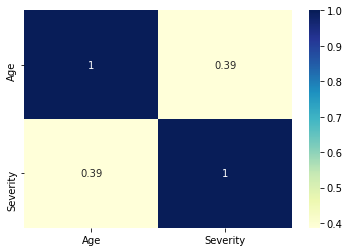

In [12]:
# plotting correlation heat-map between Continuous Variable, Age and Target Variable, Severity
sns.heatmap(df[['Age', 'Severity']].corr(), cmap="YlGnBu", annot=True)
plt.show()

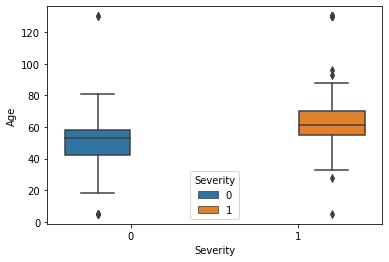

In [13]:
# Separated Box-plot of Continious Variable, Age on the basis of target variable, Severity
sns.boxplot(data = df, y = 'Age', x = 'Severity', hue = 'Severity')

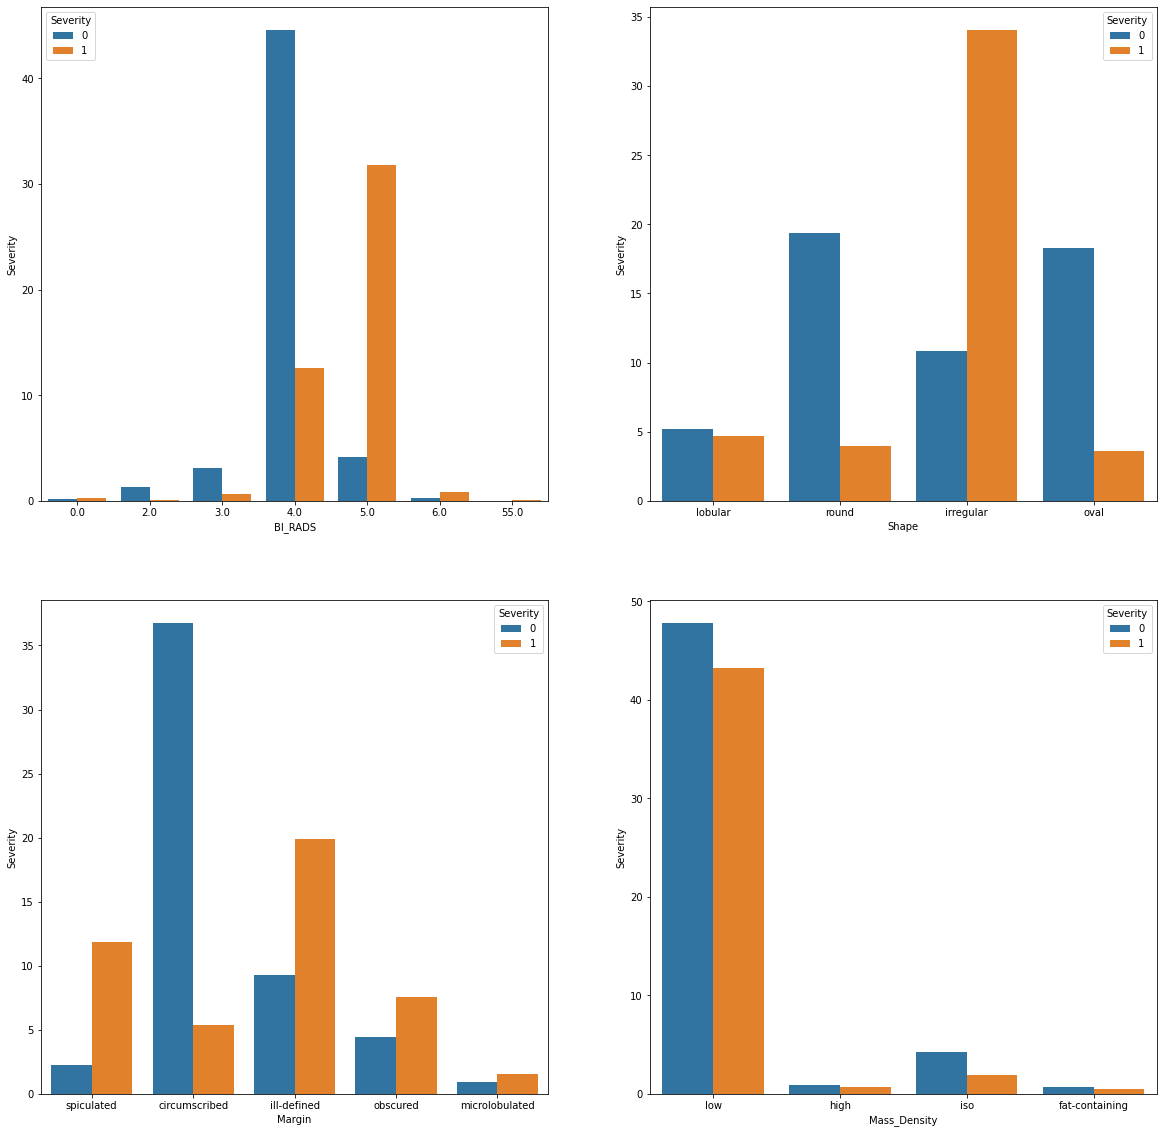

In [14]:
# Separated Category Count Distribution of Categorical Variables, BI_RADS, Shape, Margin and Mass_Density on the basis of target variable, Severity
plt.figure(figsize = (20, 20))
plt.subplot(2, 2, 1)
sns.barplot(x = 'BI_RADS', y = 'Severity', hue = "Severity", data = df, estimator = lambda x: len(x) / len(df) * 100)
plt.subplot(2, 2, 2)
sns.barplot(x = 'Shape', y = 'Severity', hue = "Severity", data = df, estimator = lambda x: len(x) / len(df) * 100)
plt.subplot(2, 2, 3)
sns.barplot(x = 'Margin', y = 'Severity', hue = "Severity", data = df, estimator = lambda x: len(x) / len(df) * 100)
plt.subplot(2, 2, 4)
sns.barplot(x = 'Mass_Density', y = 'Severity', hue = "Severity", data = df, estimator = lambda x: len(x) / len(df) * 100)
plt.show()

# Outlier Treatment by capping the outliers at the Lower and Upper End

In [15]:
lower_cap_limit = np.percentile(df['Age'], 25) - 1.5*iqr(df['Age'])
upper_cap_limit = np.percentile(df['Age'], 75) + 1.5*iqr(df['Age'])
df['Age'][df['Age'] <= lower_cap_limit] = lower_cap_limit
df['Age'][df['Age'] >= upper_cap_limit] = upper_cap_limit

# Data Preparation

In [16]:
# spliting into X (features) and y (variables)
X = df.loc[:,[x for x in list(df.columns) if x != 'Severity']]
y = df['Severity']

In [17]:
# As Mass_Density is an ordinal variable, so the textual data is converted to ordinal numerals
X['Mass_Density'] = X['Mass_Density'].map({'high' : 1, 
                                           'iso' : 2, 
                                           'low' : 3, 
                                           'fat-containing' : 4})

In [18]:
# converting the nominal variables into dummy variables and deleting the original nominals
nominal_features = ['Shape', 'Margin']
X_nominal = X[nominal_features]
X = X.drop(nominal_features, axis = 1)
df_dummies = pd.get_dummies(X_nominal, drop_first=True)
X = pd.concat([X, df_dummies], axis = 1)

In [19]:
# features considered for modelling...
print(X.columns)

Index(['BI_RADS', 'Age', 'Mass_Density', 'Shape_lobular', 'Shape_oval',
       'Shape_round', 'Margin_ill-defined', 'Margin_microlobulated',
       'Margin_obscured', 'Margin_spiculated'],
      dtype='object')


## Feature Descriptions:
### 1. BI_RADS: Assessment (ordinal, categorical)
### 2. Age: Age (continuous)
### 3. Mass_Density: Density (ordinal, categorical)
### 4. Shape_lobular: Whether the mass shape is lobular or not (binominal, categorical)
### 5. Shape_oval: Whether the mass shape is oval or not (binominal, categorical)
### 6. Shape_round: Whether the mass shape is round or not (binominal, categorical)
### 7. Margin_ill-defined: Whether the mass margin is ill-defined or not (binominal, categorical)
### 8. Margin_microlobulated: Whether the mass margin is microlobulated or not (binominal, categorical)
### 9. Margin_obscured: Whether the mass margin is obscured or not (binominal, categorical)
### 10. Margin_spiculated: Whether the mass margin is spiculated or not (binominal, categorical)

# Modelling with Random Forest Classifier
## As, Random Forest is a tree ensemble model based out of bagging, it can model non-linear decisions. Hence, it is employed to expect enhanced Model Performance

In [20]:
# splitting into train and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.8,
                                                    test_size = 0.2, random_state=201)

In [21]:
# scaling the continiuous variable, Age
scaler = StandardScaler()
X_train['Age'] = scaler.fit_transform(np.array(X_train['Age']).reshape(-1, 1))
X_test['Age'] = scaler.transform(np.array(X_test['Age']).reshape(-1, 1))

### GridSearchCrossValidation with Stratified-5-fold Hyper-parameter tuning the Random Forest Classifier Model with number of estimators and max_depth as the hyper-parameters tuned
#### In Grid-Search, Recall is used as the scoring metric as in this Breast Cancer Detection Problem, number of False Negatives (actually Maligant but predicted Benign), needs to be reduced

In [22]:
rf = RandomForestClassifier(random_state = 1234)
params = {'n_estimators':[100,150,200,250,300,350,400,450,500], 'max_depth':[3,4,5]}

# creating 5 folds
folds = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 1234)

# creating gridsearch object with recall as scoring metric
model = GridSearchCV(estimator = rf, cv = folds, param_grid = params, scoring = 'recall', verbose = 1)

In [23]:
# fitting model
model.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 135 out of 135 | elapsed:  2.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1234, shuffle=True),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=1234, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500], 'max_depth': [3, 4, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=1)

In [24]:
# printing best hyperparameters
print("Best Recall: ", model.best_score_)
print("Best hyperparameters: ", model.best_params_)

Best Recall:  0.8277271412037037
Best hyperparameters:  {'max_depth': 5, 'n_estimators': 200}


In [25]:
model_rf = RandomForestClassifier(n_estimators = 200, max_depth = 5, random_state = 1234).fit(X_train, y_train)

In [26]:
y_train_pred_prob = model_rf.predict_proba(X_train) # getting the predicted probabilities for the Training Set
y_train_pred = model_rf.predict(X_train) # getting the predictions for the Training Set

In [27]:
y_train_pred_final = pd.DataFrame({'Pred':y_train_pred, 'Prob':y_train_pred_prob[:,1]})
y_train_pred_final.head()

,Pred,Prob
0,0,0.455388
1,0,0.125498
2,0,0.373479
3,0,0.192793
4,0,0.121293


In [28]:
# creating columns with different probability cutoffs
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Pred,Prob,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,0.455388,1,1,1,1,1,0,0,0,0,0
1,0,0.125498,1,1,0,0,0,0,0,0,0,0
2,0,0.373479,1,1,1,1,0,0,0,0,0,0
3,0,0.192793,1,1,0,0,0,0,0,0,0,0
4,0,0.121293,1,1,0,0,0,0,0,0,0,0


In [29]:
# calculating accuracy sensitivity and specificity for various probability cutoffs
cutoff_df = pd.DataFrame(columns = ['prob','accuracy','sensitivity','specificity'])

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train, y_train_pred_final[i])
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] = [i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy  sensitivity  specificity
0.0   0.0  0.468750     1.000000     0.000000
0.1   0.1  0.602865     0.994444     0.257353
0.2   0.2  0.795573     0.961111     0.649510
0.3   0.3  0.839844     0.927778     0.762255
0.4   0.4  0.859375     0.869444     0.850490
0.5   0.5  0.860677     0.847222     0.872549
0.6   0.6  0.851562     0.783333     0.911765
0.7   0.7  0.846354     0.733333     0.946078
0.8   0.8  0.800781     0.613889     0.965686
0.9   0.9  0.631510     0.216667     0.997549


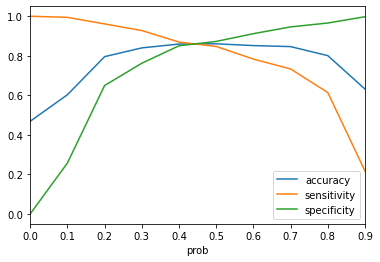

In [30]:
# plotting accuracy sensitivity (recall) and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensitivity','specificity'])
plt.show()

### selecting the cut-off (threshold) to be 0.4 i.e., slightly left to the point of intersection for recall (sensitivity) boosting

In [31]:
y_train_pred = np.array([1 if x >= 0.4 else 0 for x in y_train_pred])
y_test_pred = np.array([1 if x >= 0.4 else 0 for x in model_rf.predict(X_test)])

Training Accuracy:  0.8606770833333334
Test Accuracy:  0.8082901554404145


Training Confusion Matrix: 
[[356  52]
 [ 55 305]]
Test Confusion Matrix: 
[[86 22]
 [15 70]]


Training Precision:  0.8543417366946778
Test Precision:  0.7608695652173914


Training Recall:  0.8472222222222222
Test Recall:  0.8235294117647058


Training F1-Score:  0.8507670850767084
Test F1-Score:  0.7909604519774012


Training AUC:  0.9317912581699345
Test AUC:  0.8954248366013072


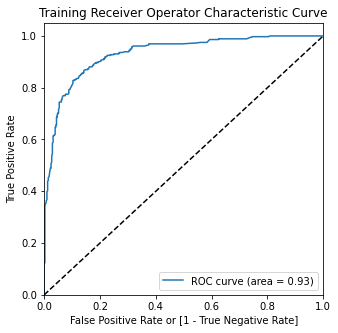

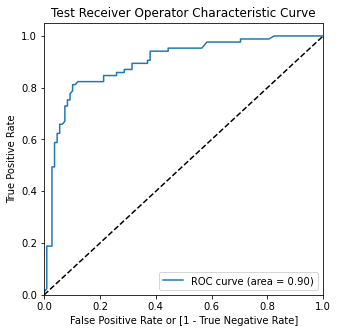

In [32]:
# FINAL MODEL RESULTS

# Accuracy
print('Training Accuracy: ', accuracy_score(y_train, y_train_pred))
print('Test Accuracy: ', accuracy_score(y_test, y_test_pred))
print('\n')
# Confusion Matrix
cm_train = metrics.confusion_matrix(y_train, y_train_pred)
print('Training Confusion Matrix: ')
print(cm_train)
cm_test = metrics.confusion_matrix(y_test, y_test_pred)
print('Test Confusion Matrix: ')
print(cm_test)
print('\n')
# Precision
training_precision = cm_train[1,1]/(cm_train[0,1]+cm_train[1,1])
print('Training Precision: ', training_precision)
test_precision = cm_test[1,1]/(cm_test[0,1]+cm_test[1,1])
print('Test Precision: ', test_precision)
print('\n')
# Recall
training_recall = cm_train[1,1]/(cm_train[1,0]+cm_train[1,1])
print('Training Recall: ', training_recall)
test_recall = cm_test[1,1]/(cm_test[1,0]+cm_test[1,1])
print('Test Recall: ', test_recall)
print('\n')
# F1-Score
print('Training F1-Score: ', 2*training_precision*training_recall/(training_precision+training_recall))
print('Test F1-Score: ', 2*test_precision*test_recall/(test_precision+test_recall))
print('\n')
# AUC Score and the ROC Curve
print('Training AUC: ', metrics.roc_auc_score(y_train, y_train_pred_prob[:,1]))
print('Test AUC: ', metrics.roc_auc_score(y_test, model_rf.predict_proba(X_test)[:,1]))
draw_roc(y_train, y_train_pred_prob[:,1], 'Training Receiver Operator Characteristic Curve')
draw_roc(y_test, model_rf.predict_proba(X_test)[:,1], 'Test Receiver Operator Characteristic Curve')

# Random Forest Model Performance Analysis
## AUC is considered as the ultimate metric for any Classification problem. Also, in this problem, Recall plays an important role. So, AUC and Recall are highly considered
### 1. Looking at the Training AUC and Test AUC, the Model is almost a good fit (negligible over-fitting) and Test AUC of 0.90 is a good score.
### 2. Recall Score of the Model is 0.82, which is an appreciable score.

# Model Interpretations in terms of feature importances

In [33]:
interpretations = pd.DataFrame({'features': X_train.columns, 'importances': model_rf.feature_importances_})
interpretations.sort_values(by = 'importances', ascending = False) # most important to least important features

,features,importances
0,BI_RADS,0.484854
1,Age,0.146606
9,Margin_spiculated,0.094118
6,Margin_ill-defined,0.086760
4,Shape_oval,0.077836
5,Shape_round,0.068077
2,Mass_Density,0.014659
3,Shape_lobular,0.012437
8,Margin_obscured,0.011127
7,Margin_microlobulated,0.003525


## BI_RADS Assessment is the most important feature for Breast Cancer Prediction and Margin_microlobulated is the least important for the same

## Limitation of Random Forest Classifier Model
### Though Feature Importances can be extracted from the Trained Model, but notable observations and recommendations can't be made.